https://www.kaggle.com/c/bike-sharing-demand/data?select=train.csv

- datetime: 대여 기록의 날짜와 시간 정보
- season: 계절 (1=봄, 2=여름, 3=가을, 4=겨울)
- holiday: 공휴일 여부 (0: 공휴일 아님, 1: 공휴일)
- workingday: 근무일 여부 (0: 주말 또는 공휴일, 1: 근무일)
- weather: 기상상황 (1~4)
- temp: 실제 온도
- atemp: 체감온도
- humidity: 습도
- windspeed: 풍속
- casual, registered: 비회원, 회원 대여량(train 데이터에만 있음)
- count: 총 대여량(타겟, train 데이터에만 있음)

In [171]:
# 자전거 대여량 예측 모델 

In [172]:
# LinearRegression,RandomForestRegressor
# GradientBoostingRegressor, XGBRegressor, LGBMRegressor


<br/>

---

<br/>
<br/>

# 0. 라이브러리 불러오기

In [173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# matplotlib 한글 폰트 설정 
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False # 마이너스 폰트 깨짐 방지


<br/>

---

<br/>
<br/>

# 1. 데이터 불러오기

In [174]:
# 데이터 불러오기
train_df = pd.read_csv("./data/bike-sharing-demand/train.csv")
# test_df = pd.read_csv("./data/bike-sharing-demand/test.csv")

<br/>

---

<br/>
<br/>

# 2. 데이터 탐색하기

In [175]:
# 기본 정보 확인
print(train_df.head())
train_df.info()
train_df.describe()

              datetime  season  holiday  workingday  weather  temp   atemp  \
0  2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1  2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2  2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
3  2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
4  2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

   humidity  windspeed  casual  registered  count  
0        81        0.0       3          13     16  
1        80        0.0       8          32     40  
2        80        0.0       5          27     32  
3        75        0.0       3          10     13  
4        75        0.0       0           1      1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-n

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000



'count' 변수의 분포:


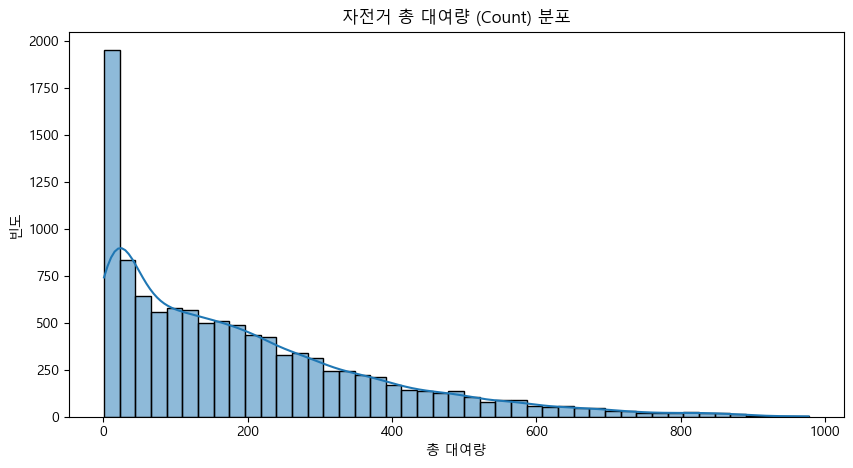

In [176]:
# 1. 'count' (총 대여량) 변수의 분포 확인
print("\n'count' 변수의 분포:")
plt.figure(figsize=(10, 5))
sns.histplot(train_df['count'], kde=True)
plt.title('자전거 총 대여량 (Count) 분포')
plt.xlabel('총 대여량')
plt.ylabel('빈도')
plt.show()

count 값이 0에 가까운 낮은 대여량에 데이터가 집중되어있다.
대여량이 증가할수록 빈도가 급격하게 줄어드는 오른쪽으로 치우친 분포를 보여준다.
모델의 예측 성능의 향상을 위해 추후 데이터 전처리 단계에서 로그변환과 같은 정규화 기법을 적용할 수도 있다.

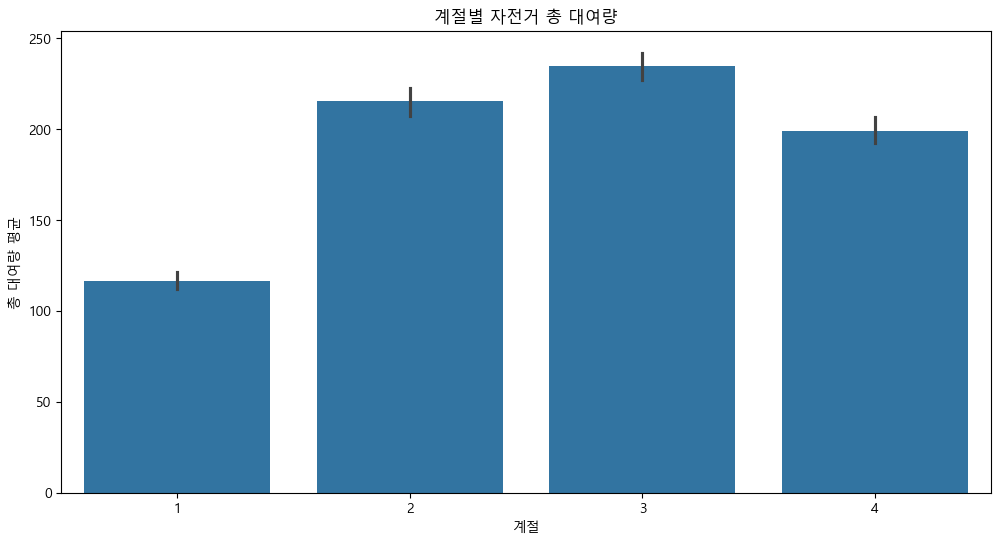

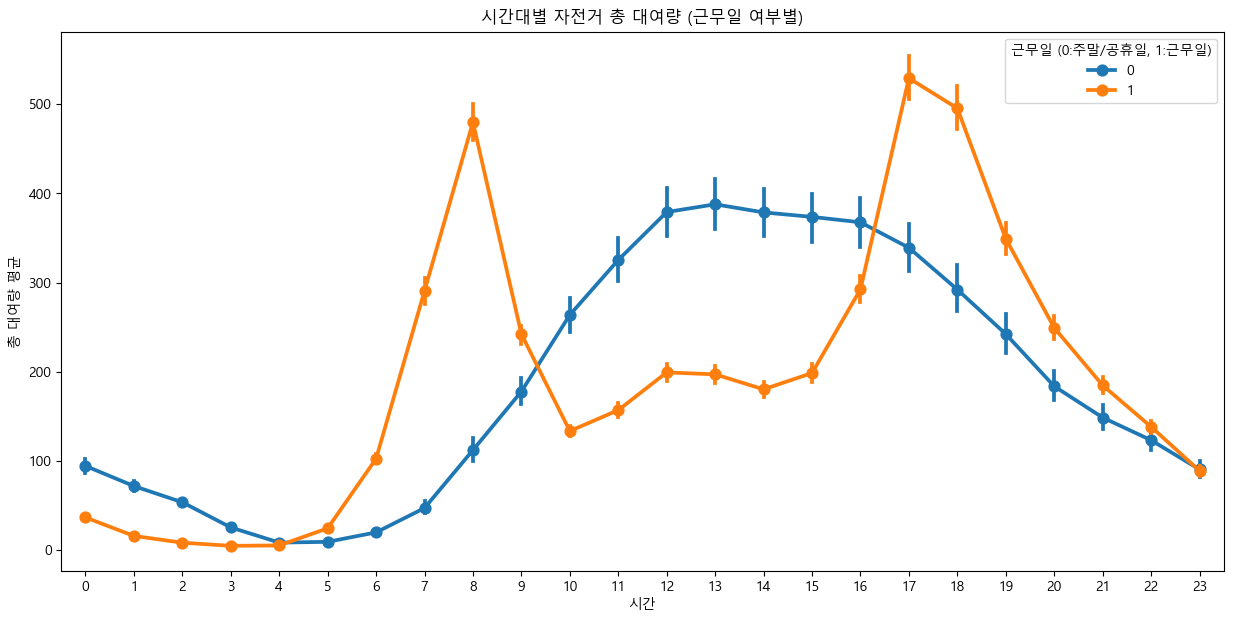

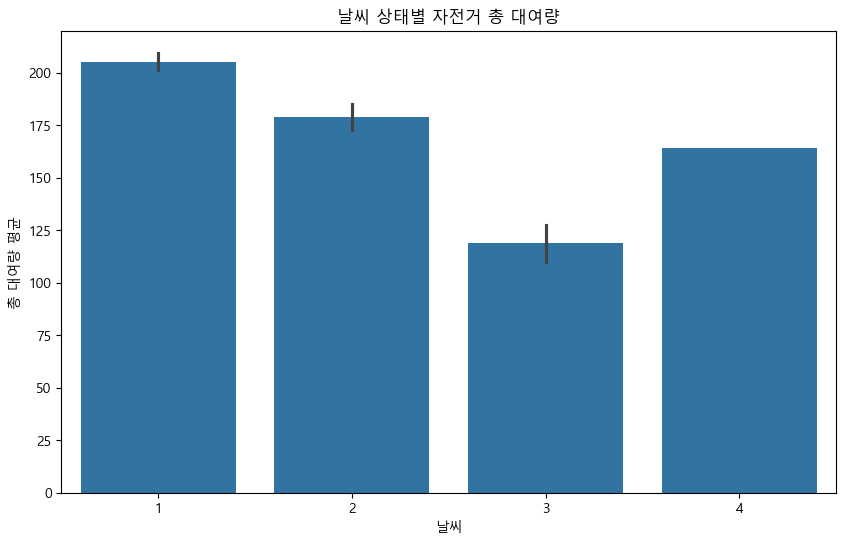

In [177]:
# 2. 범주형 변수와 'count' 간의 관계 시각화
# datetime 컬럼을 datetime 객체로 변환
train_df['datetime'] = pd.to_datetime(train_df['datetime'])

# 연, 월, 시, 요일 추출
train_df['year'] = train_df['datetime'].dt.year
train_df['month'] = train_df['datetime'].dt.month
train_df['hour'] = train_df['datetime'].dt.hour
train_df['dayofweek'] = train_df['datetime'].dt.dayofweek # 월:0 ~

# 계절별 대여량
plt.figure(figsize=(12, 6))
sns.barplot(x='season', y='count', data=train_df)
plt.title('계절별 자전거 총 대여량')
plt.xlabel('계절')
plt.ylabel('총 대여량 평균')
plt.show()

# 시간(hour)별 대여량
plt.figure(figsize=(15, 7))
sns.pointplot(x='hour', y='count', hue='workingday', data=train_df)
plt.title('시간대별 자전거 총 대여량 (근무일 여부별)')
plt.xlabel('시간')
plt.ylabel('총 대여량 평균')
plt.legend(title='근무일 (0:주말/공휴일, 1:근무일)')
plt.show()

# 날씨(weather)별 대여량
plt.figure(figsize=(10, 6))
sns.barplot(x='weather', y='count', data=train_df)
plt.title('날씨 상태별 자전거 총 대여량')
plt.xlabel('날씨')
plt.ylabel('총 대여량 평균')
plt.show()

범주형 변수와 count간의 관계
- 계절별: 가을과 여름에 대여량이 많고, 겨울 봄에 적은 경향을 보인다.
- 시간대별: 근무일에는 출퇴근 시간에 대여량이 급증하는 경향을 보인다.
- 날씨별: 날씨가 좋을수록 대여량이 많다.

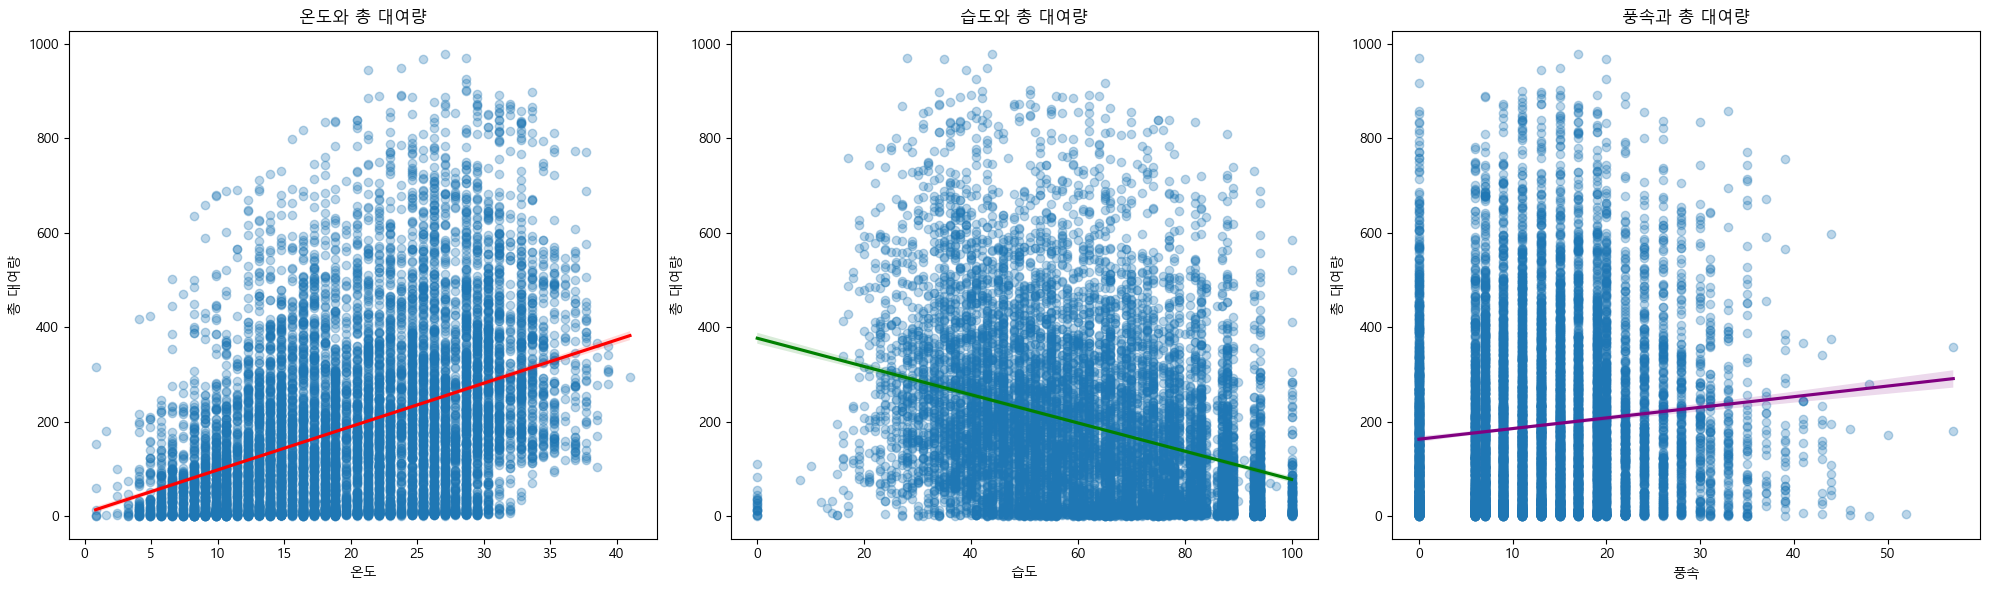

In [178]:
# 3. 수치형 변수와 'count' 간의 관계 시각화
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))

# 1) 온도(temp)와 대여량
sns.regplot(x='temp', y='count', data=train_df, ax=axes[0], scatter_kws={'alpha':0.3},line_kws={'color': 'red'})
axes[0].set_title('온도와 총 대여량')
axes[0].set_xlabel('온도')
axes[0].set_ylabel('총 대여량')

# 2) 습도(humidity)와 대여량
sns.regplot(x='humidity', y='count', data=train_df, ax=axes[1], scatter_kws={'alpha':0.3}, line_kws={'color': 'green'})
axes[1].set_title('습도와 총 대여량')
axes[1].set_xlabel('습도')
axes[1].set_ylabel('총 대여량')

# 3) 풍속(windspeed)과 대여량
sns.regplot(x='windspeed', y='count', data=train_df, ax=axes[2], scatter_kws={'alpha':0.3}, line_kws={'color': 'purple'})
axes[2].set_title('풍속과 총 대여량')
axes[2].set_xlabel('풍속')
axes[2].set_ylabel('총 대여량')

plt.tight_layout()
plt.show()

수치형 변수와 count 간의 관계
- 온도: 온도가 증가할수록 대여량도 증가한다. (양의 선형 관계)
- 습도: 회귀선의 기울기가 음수이지만, 점들이 넓게 퍼져 있어 관계의 강도는 온도만큼 강하지 않다. (약한 음의 선형 관계)
- 풍속: 풍속이 증가할수록 대여량이 감소하는 경향이 보인다.


**온도와 자전거 대여량에 가장 강한 양의 영향을 미치는 것으로 보인다.**

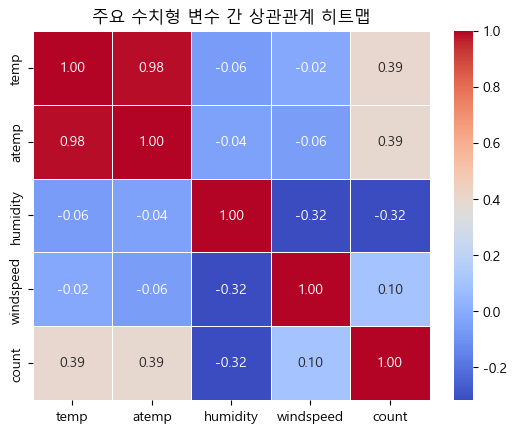

In [179]:
# 4. 변수 간 상관관계 분석
correlation_matrix = train_df[['temp', 'atemp', 'humidity', 'windspeed', 'count']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('주요 수치형 변수 간 상관관계 히트맵')
plt.show()

<br/>

---

<br/>
<br/>

# 3. 데이터 전처리

In [180]:
# 결측치 및 이상치 확인
train_df.isnull().sum()
# 결측치 없음

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
year          0
month         0
hour          0
dayofweek     0
dtype: int64

In [181]:
# 1. 'datetime' 변수를 datetime 객체로 변환
train_df['datetime'] = pd.to_datetime(train_df['datetime'])

# 2. datetime에서 새로운 피처(특성) 추출
train_df['year'] = train_df['datetime'].dt.year
train_df['month'] = train_df['datetime'].dt.month
train_df['day'] = train_df['datetime'].dt.day
train_df['hour'] = train_df['datetime'].dt.hour
train_df['dayofweek'] = train_df['datetime'].dt.dayofweek # 0:월~ 

# 'weekend' 피처 생성 (workingday와 holiday 조합)
# workingday가 0 (주말 또는 공휴일)이면 weekend를 1로, 아니면 0으로 설정
train_df['weekend'] = train_df['workingday'].apply(lambda x: 1 if x == 0 else 0)

In [182]:
print(train_df.head())

             datetime  season  holiday  workingday  weather  temp   atemp  \
0 2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1 2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2 2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
3 2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
4 2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

   humidity  windspeed  casual  registered  count  year  month  hour  \
0        81        0.0       3          13     16  2011      1     0   
1        80        0.0       8          32     40  2011      1     1   
2        80        0.0       5          27     32  2011      1     2   
3        75        0.0       3          10     13  2011      1     3   
4        75        0.0       0           1      1  2011      1     4   

   dayofweek  day  weekend  
0          5    1        1  
1          5    1        1  
2          5    1

In [183]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
 12  year        10886 non-null  int32         
 13  month       10886 non-null  int32         
 14  hour        10886 non-null  int32         
 15  dayofweek   10886 non-null  int32         
 16  day         10886 non-

In [184]:
# 범주형 변수 처리 (One-Hot Encoding) 및 불필요한 변수 제거

# 3. 범주형 변수 정의, 원-핫 인코딩
#categorical_features = ['season', 'weather', 'holiday', 'workingday', 'month', 'hour', 'dayofweek', 'year', 'weekend']
#train_df = pd.get_dummies(train_df, columns=categorical_features, drop_first=True)

# 4. 불필요한 변수 제거
drop_features = ['datetime', 'casual', 'registered', 'atemp', 'day']
train_df.drop(columns=drop_features, inplace=True)

In [185]:
print(train_df.head())

   season  holiday  workingday  weather  temp  humidity  windspeed  count  \
0       1        0           0        1  9.84        81        0.0     16   
1       1        0           0        1  9.02        80        0.0     40   
2       1        0           0        1  9.02        80        0.0     32   
3       1        0           0        1  9.84        75        0.0     13   
4       1        0           0        1  9.84        75        0.0      1   

   year  month  hour  dayofweek  weekend  
0  2011      1     0          5        1  
1  2011      1     1          5        1  
2  2011      1     2          5        1  
3  2011      1     3          5        1  
4  2011      1     4          5        1  


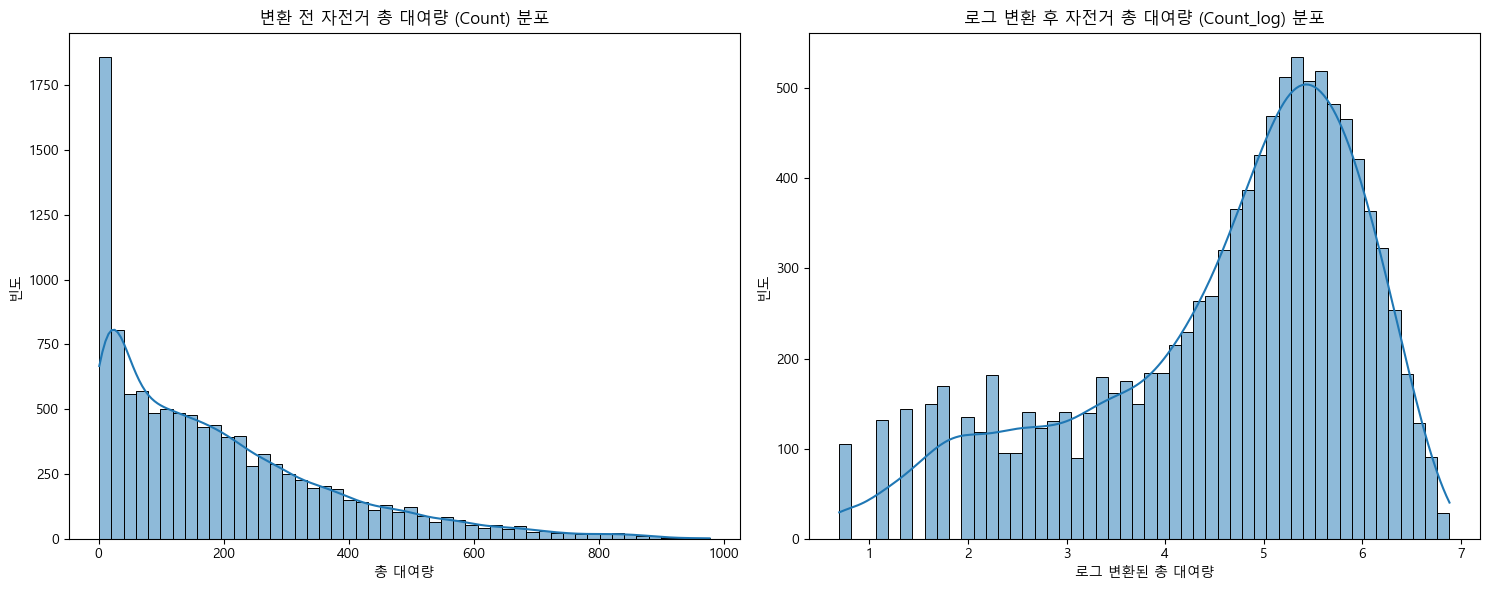

In [186]:
# 'count' 변수 로그 변환 
train_df['count_log'] = np.log1p(train_df['count'])

# 변환 전후의 'count' 분포 시각화 비교
plt.figure(figsize=(15, 6))

# 변환 전 'count' 분포
plt.subplot(1, 2, 1)
sns.histplot(train_df['count'], kde=True, bins=50)
plt.title('변환 전 자전거 총 대여량 (Count) 분포')
plt.xlabel('총 대여량')
plt.ylabel('빈도')

# 변환 후 'count_log' 분포
plt.subplot(1, 2, 2)
sns.histplot(train_df['count_log'], kde=True, bins=50)
plt.title('로그 변환 후 자전거 총 대여량 (Count_log) 분포')
plt.xlabel('로그 변환된 총 대여량')
plt.ylabel('빈도')

plt.tight_layout()
plt.show()

<br/>

---

<br/>
<br/>

# 4. 모델 선택 및 학습

In [187]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [188]:
train_df.head()

,season,holiday,workingday,weather,temp,humidity,windspeed,count,year,month,hour,dayofweek,weekend,count_log
0,1,0,0,1,9.84,81,0.0,16,2011,1,0,5,1,2.833213
1,1,0,0,1,9.02,80,0.0,40,2011,1,1,5,1,3.713572
2,1,0,0,1,9.02,80,0.0,32,2011,1,2,5,1,3.496508
3,1,0,0,1,9.84,75,0.0,13,2011,1,3,5,1,2.639057
4,1,0,0,1,9.84,75,0.0,1,2011,1,4,5,1,0.693147


In [189]:
drop_features

['datetime', 'casual', 'registered', 'atemp', 'day']

In [190]:
# X, y 분리
y = train_df['count_log']
X = train_df.drop(columns=['count_log'])

In [191]:
# 데이터 분할
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = np.asarray(X_train)
X_val = np.asarray(X_val)
y_train = np.asarray(y_train)
y_val = np.asarray(y_val)

In [192]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

models = {
    'Linear Regression': LinearRegression(),
    'Random Forest Regressor': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting Regressor': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGB Regressor': XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'LGBM Regressor': LGBMRegressor(n_estimators=100, random_state=42, n_jobs=-1),
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_log = model.predict(X_val)
    
    y_pred_original = np.expm1(y_pred_log)
    y_val_original = np.expm1(y_val)

    # RMSE 계산
    score = rmse(y_val_original, y_pred_original)
    results[name] = score
    print(f"{name} RMSE: {score:.4f}")

Linear Regression RMSE: 491.5671
Random Forest Regressor RMSE: 0.9340
Gradient Boosting Regressor RMSE: 2.3321
XGB Regressor RMSE: 0.7735
LGBM Regressor RMSE: 2.9844


Random Forest 가장 좋은 성능을 보임

<br/>

---

<br/>
<br/>

# 5. 모델 평가

In [193]:
y_val_pred_log = model.predict(X_val)

y_val_pred = np.expm1(y_val_pred_log) # 예측값 역변환
y_val_original = np.expm1(y_val) # 실제값 역변환

In [194]:
# 3. 평가 지표 계산 (RMSE, MAE, R-squared)
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_score = rmse(y_val_original, y_val_pred)
mae_score = mean_absolute_error(y_val_original, y_val_pred)
r2_score_val = r2_score(y_val_original, y_val_pred)

In [195]:
rmse_score = rmse(y_val_original, y_val_pred)
mae_score = mean_absolute_error(y_val_original, y_val_pred)
r2_score_val = r2_score(y_val_original, y_val_pred)

print(f"\n--- Random Forest Regressor 평가 결과 ---")
print(f"RMSE (Root Mean Squared Error): {rmse_score:.4f}")
print(f"MAE (Mean Absolute Error): {mae_score:.4f}")
print(f"R-squared (결정계수): {r2_score_val:.4f}")


--- Random Forest Regressor 평가 결과 ---
RMSE (Root Mean Squared Error): 2.9844
MAE (Mean Absolute Error): 0.7947
R-squared (결정계수): 0.9997
